# Navier-Stokes Equation

Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

from jax import config
config.update("jax_enable_x64", True)

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data

In [2]:
from dataloaders import *

x_train, y_train, x_test, y_test, x_grid, y_grid = get_navier_stokes_data(1000, 1000)

(40000, 4096) (40000, 4096)
(32000, 4096) (32000, 4096)
(8000, 4096) (8000, 4096)


Visualise input and output data

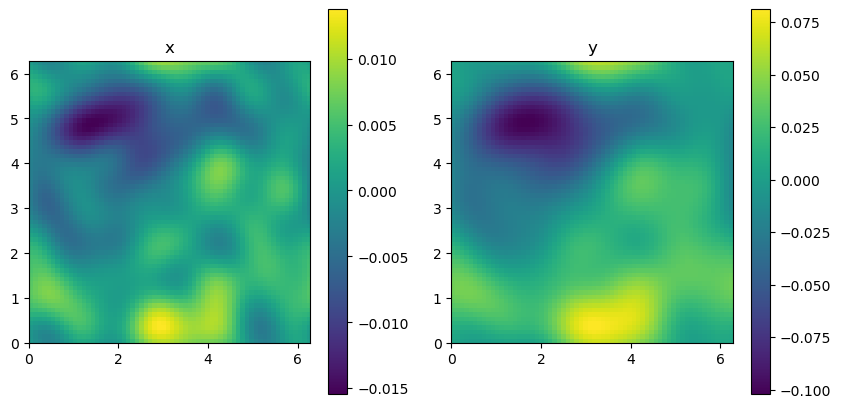

In [3]:
index_to_plot = 12

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

Define model

In [4]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

Determine the number of PCs required to capture a given amount of variance

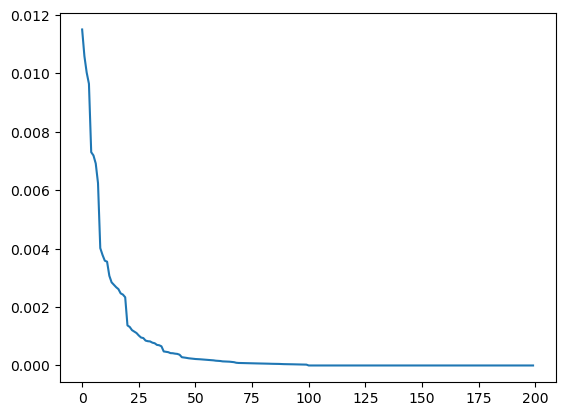

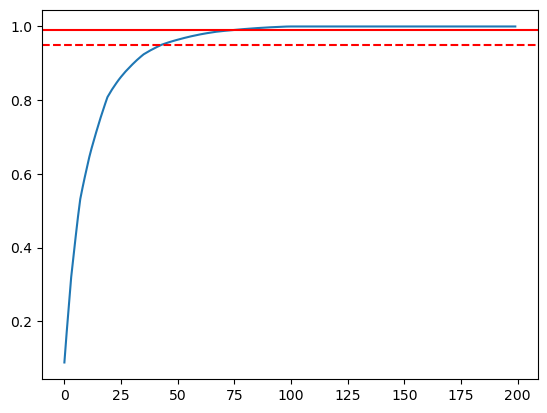

[0.08806532 0.16914671 0.24592865 0.31975153 0.37565711 0.4306989
 0.48364357 0.53144437 0.56220123 0.5911655  0.6186316  0.64583928
 0.66934926 0.69114094 0.71230003 0.7328207  0.75283948 0.77173927
 0.79032014 0.80820048 0.81870547 0.82880227 0.83806654 0.84695795
 0.85545891 0.86331605 0.87064223 0.87782419 0.88434588 0.8907077
 0.89701076 0.90298904 0.90882043 0.91422075 0.91952328 0.92454648
 0.92823023 0.93181083 0.93529848 0.93853608 0.94174379 0.94484169
 0.94787542 0.9506953  0.95286548 0.95495394 0.95695001 0.95883949
 0.96065349 0.96241555 0.96411032 0.96578331 0.96740923 0.96898642
 0.97053185 0.97199931 0.97341959 0.97479169 0.97613395 0.97738797
 0.97860276 0.97977195 0.98084696 0.98190034 0.98290647 0.98390033
 0.98484407 0.98571117 0.9864241  0.98708493 0.98772764 0.98836133
 0.98894933 0.98953289 0.99010622 0.99066887 0.99122154 0.99176339
 0.99229631 0.99281448 0.99332249 0.99380395 0.99427681 0.99472291
 0.9951597  0.99559316 0.9960137  0.99641646 0.99678946 0.997142

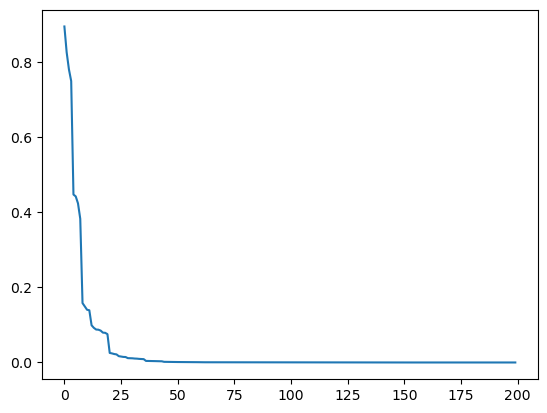

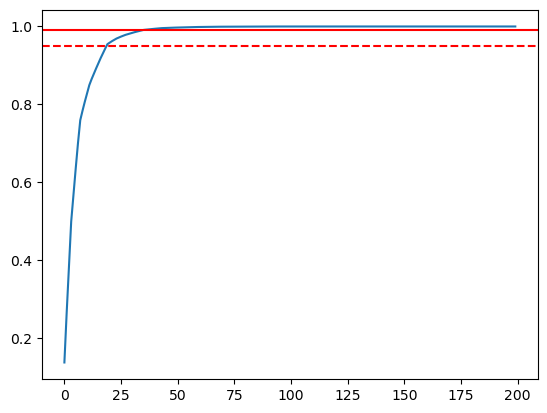

[0.1373584  0.26416519 0.38400164 0.49904521 0.56770535 0.63560307
 0.70065376 0.75939651 0.7836739  0.80661104 0.82816418 0.84950918
 0.86470825 0.87886954 0.8923413  0.90574299 0.91877511 0.9309797
 0.94310364 0.95468462 0.95858949 0.96229663 0.96574686 0.96904938
 0.97163295 0.97404732 0.97632062 0.9785552  0.98032683 0.98207268
 0.98378174 0.98539131 0.98695733 0.98842582 0.9898596  0.99122247
 0.99186221 0.99249164 0.99309415 0.99365791 0.99421516 0.99475676
 0.99529543 0.99577873 0.99604339 0.99628916 0.99651708 0.99673656
 0.99693302 0.99712349 0.99730631 0.99748689 0.99766078 0.99782942
 0.99798994 0.99814163 0.99828413 0.99841953 0.99854884 0.99866865
 0.99876751 0.99886024 0.99894574 0.9990298  0.99911071 0.99919056
 0.99926444 0.99933347 0.99936927 0.99940311 0.99943661 0.99946815
 0.99949798 0.99952763 0.9995571  0.99958546 0.99961332 0.99963994
 0.99966604 0.99969174 0.99971639 0.99974011 0.99976259 0.99978451
 0.99980563 0.99982631 0.99984647 0.99986501 0.99987952 0.99989

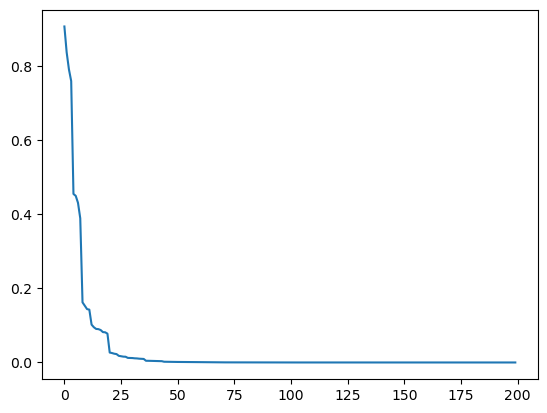

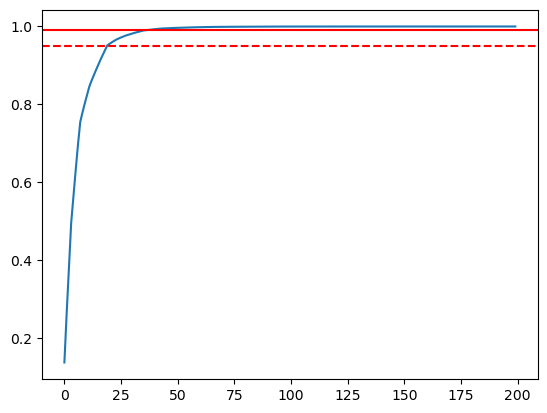

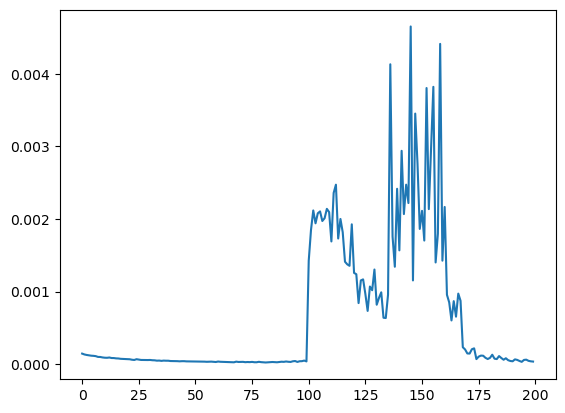

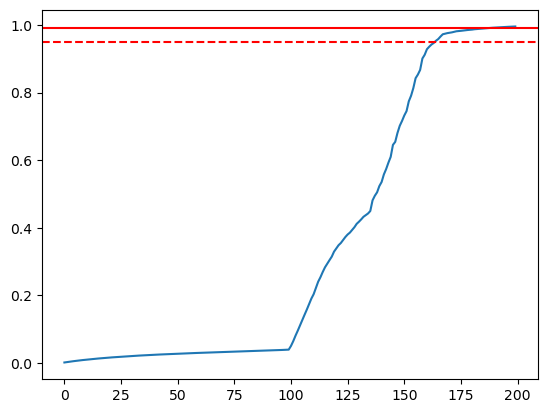

[0.00111503 0.00213992 0.00311258 0.0040481  0.00494415 0.00582388
 0.00667196 0.00743762 0.00819758 0.00890866 0.00959067 0.0102645
 0.01096927 0.01161974 0.01226527 0.01287739 0.01347856 0.01404433
 0.01460091 0.01513747 0.01567237 0.01619162 0.01666127 0.01710652
 0.01763135 0.01811479 0.01856104 0.01900273 0.01944802 0.01988449
 0.02032935 0.02074572 0.0211536  0.02152503 0.0219067  0.02225519
 0.02263339 0.02299847 0.02336349 0.02369654 0.02402737 0.02434653
 0.02466567 0.02496723 0.02528394 0.02560138 0.02589846 0.02619197
 0.02649332 0.02677349 0.02704595 0.02731999 0.02759497 0.0278566
 0.02812354 0.02837551 0.0286414  0.02891093 0.02916521 0.02939512
 0.02967385 0.02992727 0.03017142 0.03040575 0.03063377 0.03085363
 0.03107155 0.03127137 0.03153932 0.03177178 0.03201171 0.03225716
 0.03246752 0.03269583 0.03291212 0.03315242 0.03335717 0.03356021
 0.03381048 0.03402547 0.03422628 0.03440614 0.03460121 0.03480879
 0.0350387  0.03525413 0.03545437 0.03568806 0.03594727 0.036192

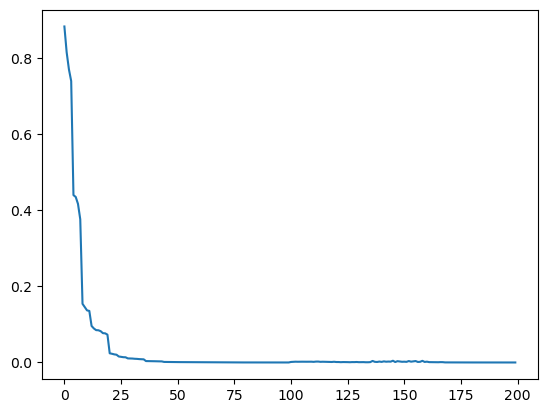

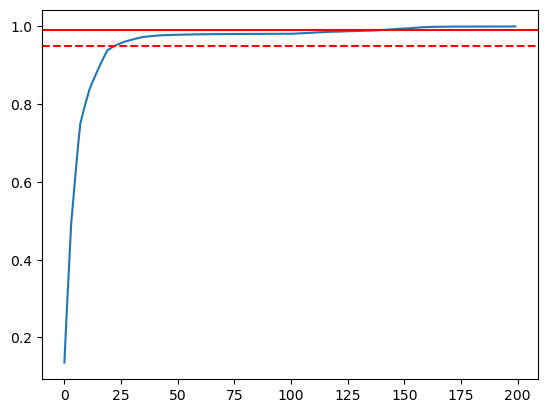

[0.13561814 0.2608216  0.37913976 0.49272464 0.56028436 0.62709733
 0.6911058  0.74890788 0.7725872  0.79496205 0.81598152 0.83679842
 0.85154354 0.86528479 0.87834815 0.89135361 0.90399768 0.91583879
 0.9276037  0.93884058 0.94254946 0.94606786 0.94934563 0.95248371
 0.95490912 0.95717734 0.95931499 0.96141574 0.9630682  0.96469692
 0.96628949 0.96778939 0.96924828 0.97061809 0.971954   0.97322474
 0.97380007 0.9743668  0.97490792 0.97541558 0.97591678 0.97640421
 0.97688922 0.97732351 0.97755118 0.97776192 0.97795668 0.97814463
 0.97831093 0.97847248 0.97862743 0.97878046 0.97892717 0.97906975
 0.97920511 0.97933299 0.97945252 0.97956608 0.97967377 0.97977383
 0.9798537  0.97992803 0.97999699 0.98006491 0.98013029 0.98019472
 0.98025421 0.98031012 0.9803368  0.98036186 0.98038732 0.98041101
 0.98043317 0.98045569 0.98047818 0.98049984 0.98052068 0.9805405
 0.98056055 0.98058028 0.98059858 0.98061616 0.98063293 0.98065015
 0.98066697 0.98068294 0.9806986  0.98071368 0.98072572 0.98073

In [5]:
def stand(x):
    return (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)

large_n = 200 # used as the upper limit of number of PCs to use, set such that it's larger than what's required

# these lines are currently just for testing this cell, comment when running full code
# x_train = stand(x_train)
# y_train = stand(y_train)

### separate PCAs
x_pca = PCA(n_components = large_n)
x_pca.fit(x_train)

plt.plot(x_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(x_pca.explained_variance_ratio_))

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > 0.95)[0][0]

y_pca = PCA(n_components = large_n)
y_pca.fit(y_train)

plt.plot(y_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(y_pca.explained_variance_ratio_))

m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > 0.99)[0][0]

print(f'n, m with individually-trained PCAs: {n, m}')

### combined PCA
combined_pca_full = PCA(n_components = 999)
combined_pca = PCA(n_components = large_n)
combined_train = np.concatenate((x_train, y_train), axis = 1)
combined_train_pca_full = combined_pca_full.fit_transform(combined_train)
combined_train_pca = combined_pca.fit_transform(combined_train)
print('does combined pca')

x_pca = PCA(n_components = large_n)
x_pca_full = PCA(n_components = 999)
y_pca = PCA(n_components = large_n)
y_pca_full = PCA(n_components = 999)

x_pca.components_ = combined_pca.components_[:, :4096]
x_pca_full.components_ = combined_pca_full.components_[:, :4096]
x_pca.mean_ = combined_pca.mean_[:4096]
x_pca_full.mean_ = combined_pca_full.mean_[:4096]

y_pca.components_ = combined_pca.components_[:, 4096:]
y_pca_full.components_ = combined_pca_full.components_[:, 4096:]
y_pca.mean_ = combined_pca.mean_[4096:]
y_pca_full.mean_ = combined_pca_full.mean_[4096:]

def compute_eigenvalues(components, original_data):
    # Reconstruct the covariance matrix from the components
    # `components` are the PCA components for either x_pca or y_pca
    # `original_data` should be x_train or y_train as applicable
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return eigenvalues

def get_total_var(components, original_data):
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return total_variance

x_eigenvalues = compute_eigenvalues(x_pca.components_, x_train - x_pca.mean_)
y_eigenvalues = compute_eigenvalues(y_pca.components_, y_train - y_pca.mean_)

x_pca.explained_variance_ratio_ = x_eigenvalues / get_total_var(x_pca_full.components_, x_train - x_pca_full.mean_)
y_pca.explained_variance_ratio_ = y_eigenvalues / get_total_var(y_pca_full.components_, y_train - y_pca_full.mean_)

x_pca.explained_variance_ = x_eigenvalues
y_pca.explained_variance_ = y_eigenvalues

plt.plot(combined_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(combined_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

plt.plot(x_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(x_pca.explained_variance_ratio_))

plt.plot(y_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(y_pca.explained_variance_ratio_))

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > 0.95)[0][0]
m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > 0.99)[0][0]

print(f'n, m with combined PCA: {n, m}')

# Train

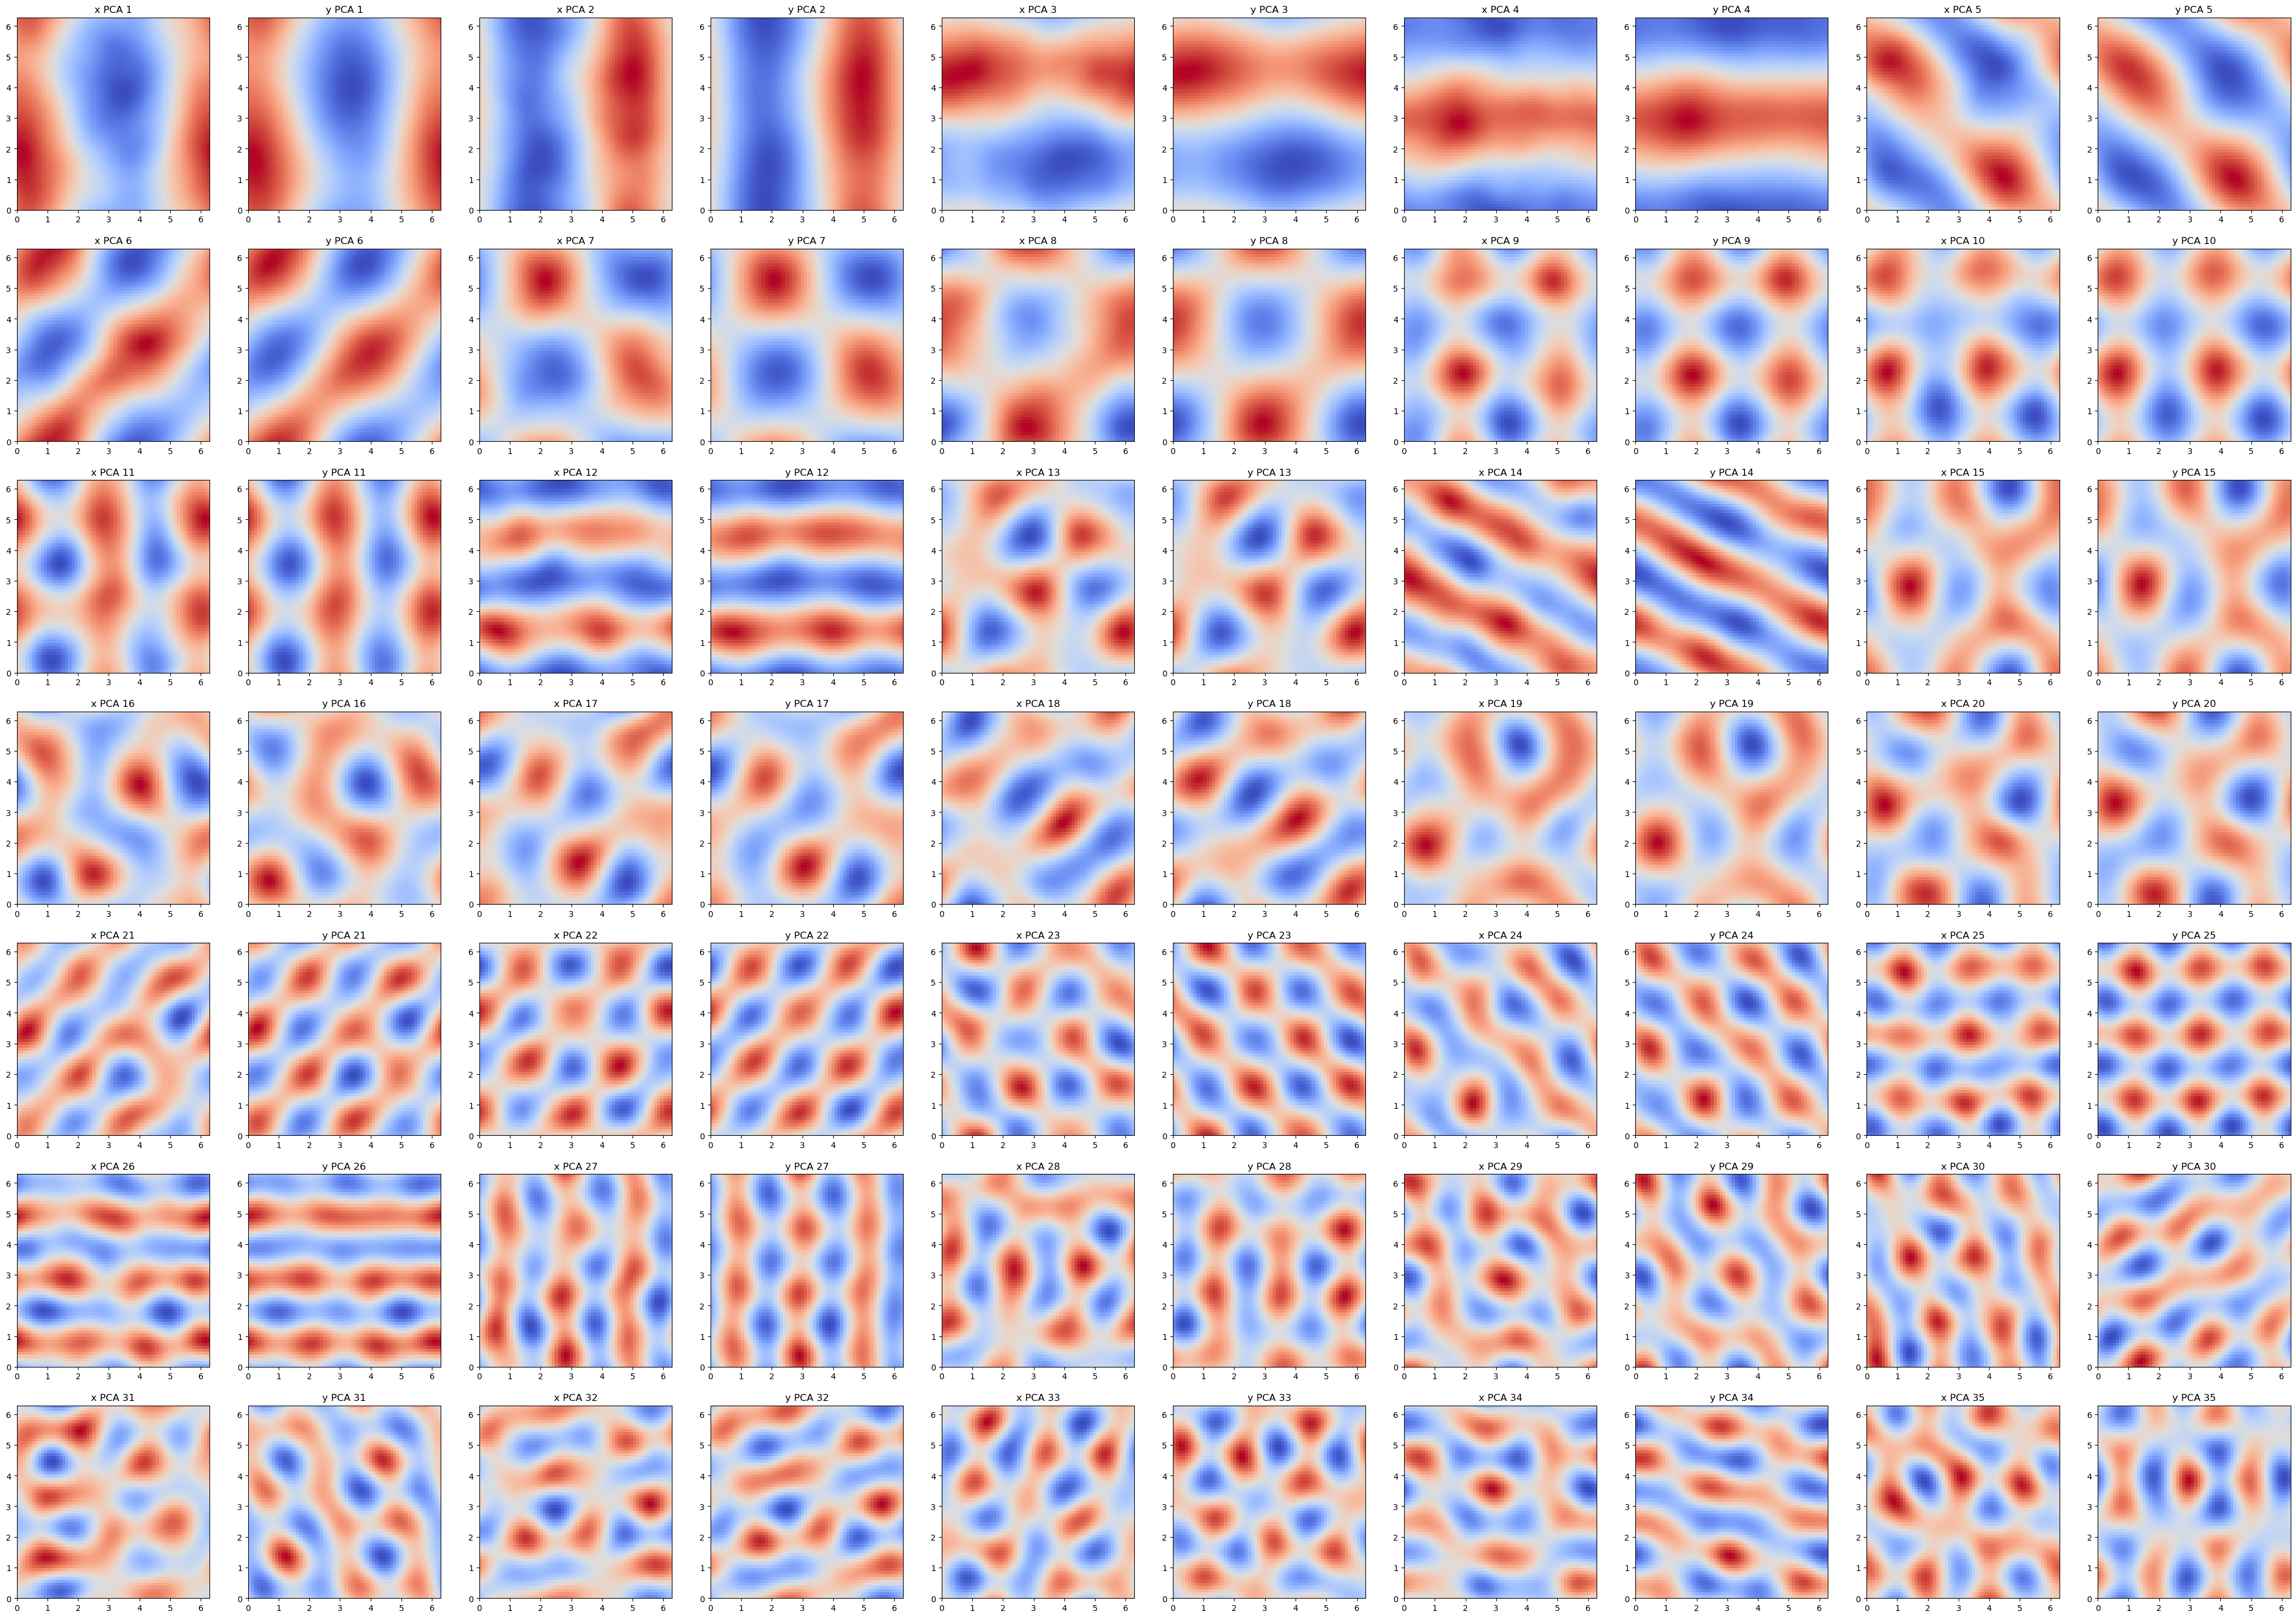

KeyboardInterrupt: 

In [6]:
x_train_pca = PCA(n_components=45).fit(x_train)
y_train_pca = PCA(n_components=35).fit(y_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(x_train_pca.components_[int(i/2), :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(y_train_pca.components_[int(i/2), :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(x_train_pca.components_[i, :], y_train_pca.components_[i, :], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(x_train_pca.components_[i, :], y_train_pca.components_[i, :])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

x_train_pca = x_train_pca.transform(x_train)
y_train_pca = y_train_pca.transform(y_train)

for i in range(5):
    plt.figure()
    plt.hist(x_train_pca[:, i], bins=50, label = f'x_train_pca {i+1}', alpha=0.5)
    plt.hist(y_train_pca[:, i], bins=50, label = f'y_train_pca {i+1}', alpha=0.5)
    plt.show()

print('standardising')

for i in range(5):
    x_train_pca_stand_i = (x_train_pca[:, i] - x_train_pca[:, i].mean(axis = 0))/x_train_pca[:, i].std(axis = 0)
    y_train_pca_stand_i = (y_train_pca[:, i] - y_train_pca[:, i].mean(axis = 0))/y_train_pca[:, i].std(axis = 0)
    plt.figure()
    plt.hist(x_train_pca_stand_i, bins=50, label = f'x_train_pca_stand {i+1}', alpha=0.5)
    plt.hist(y_train_pca_stand_i, bins=50, label = f'y_train_pca_stand {i+1}', alpha=0.5)
    plt.show()


(1000, 8192)


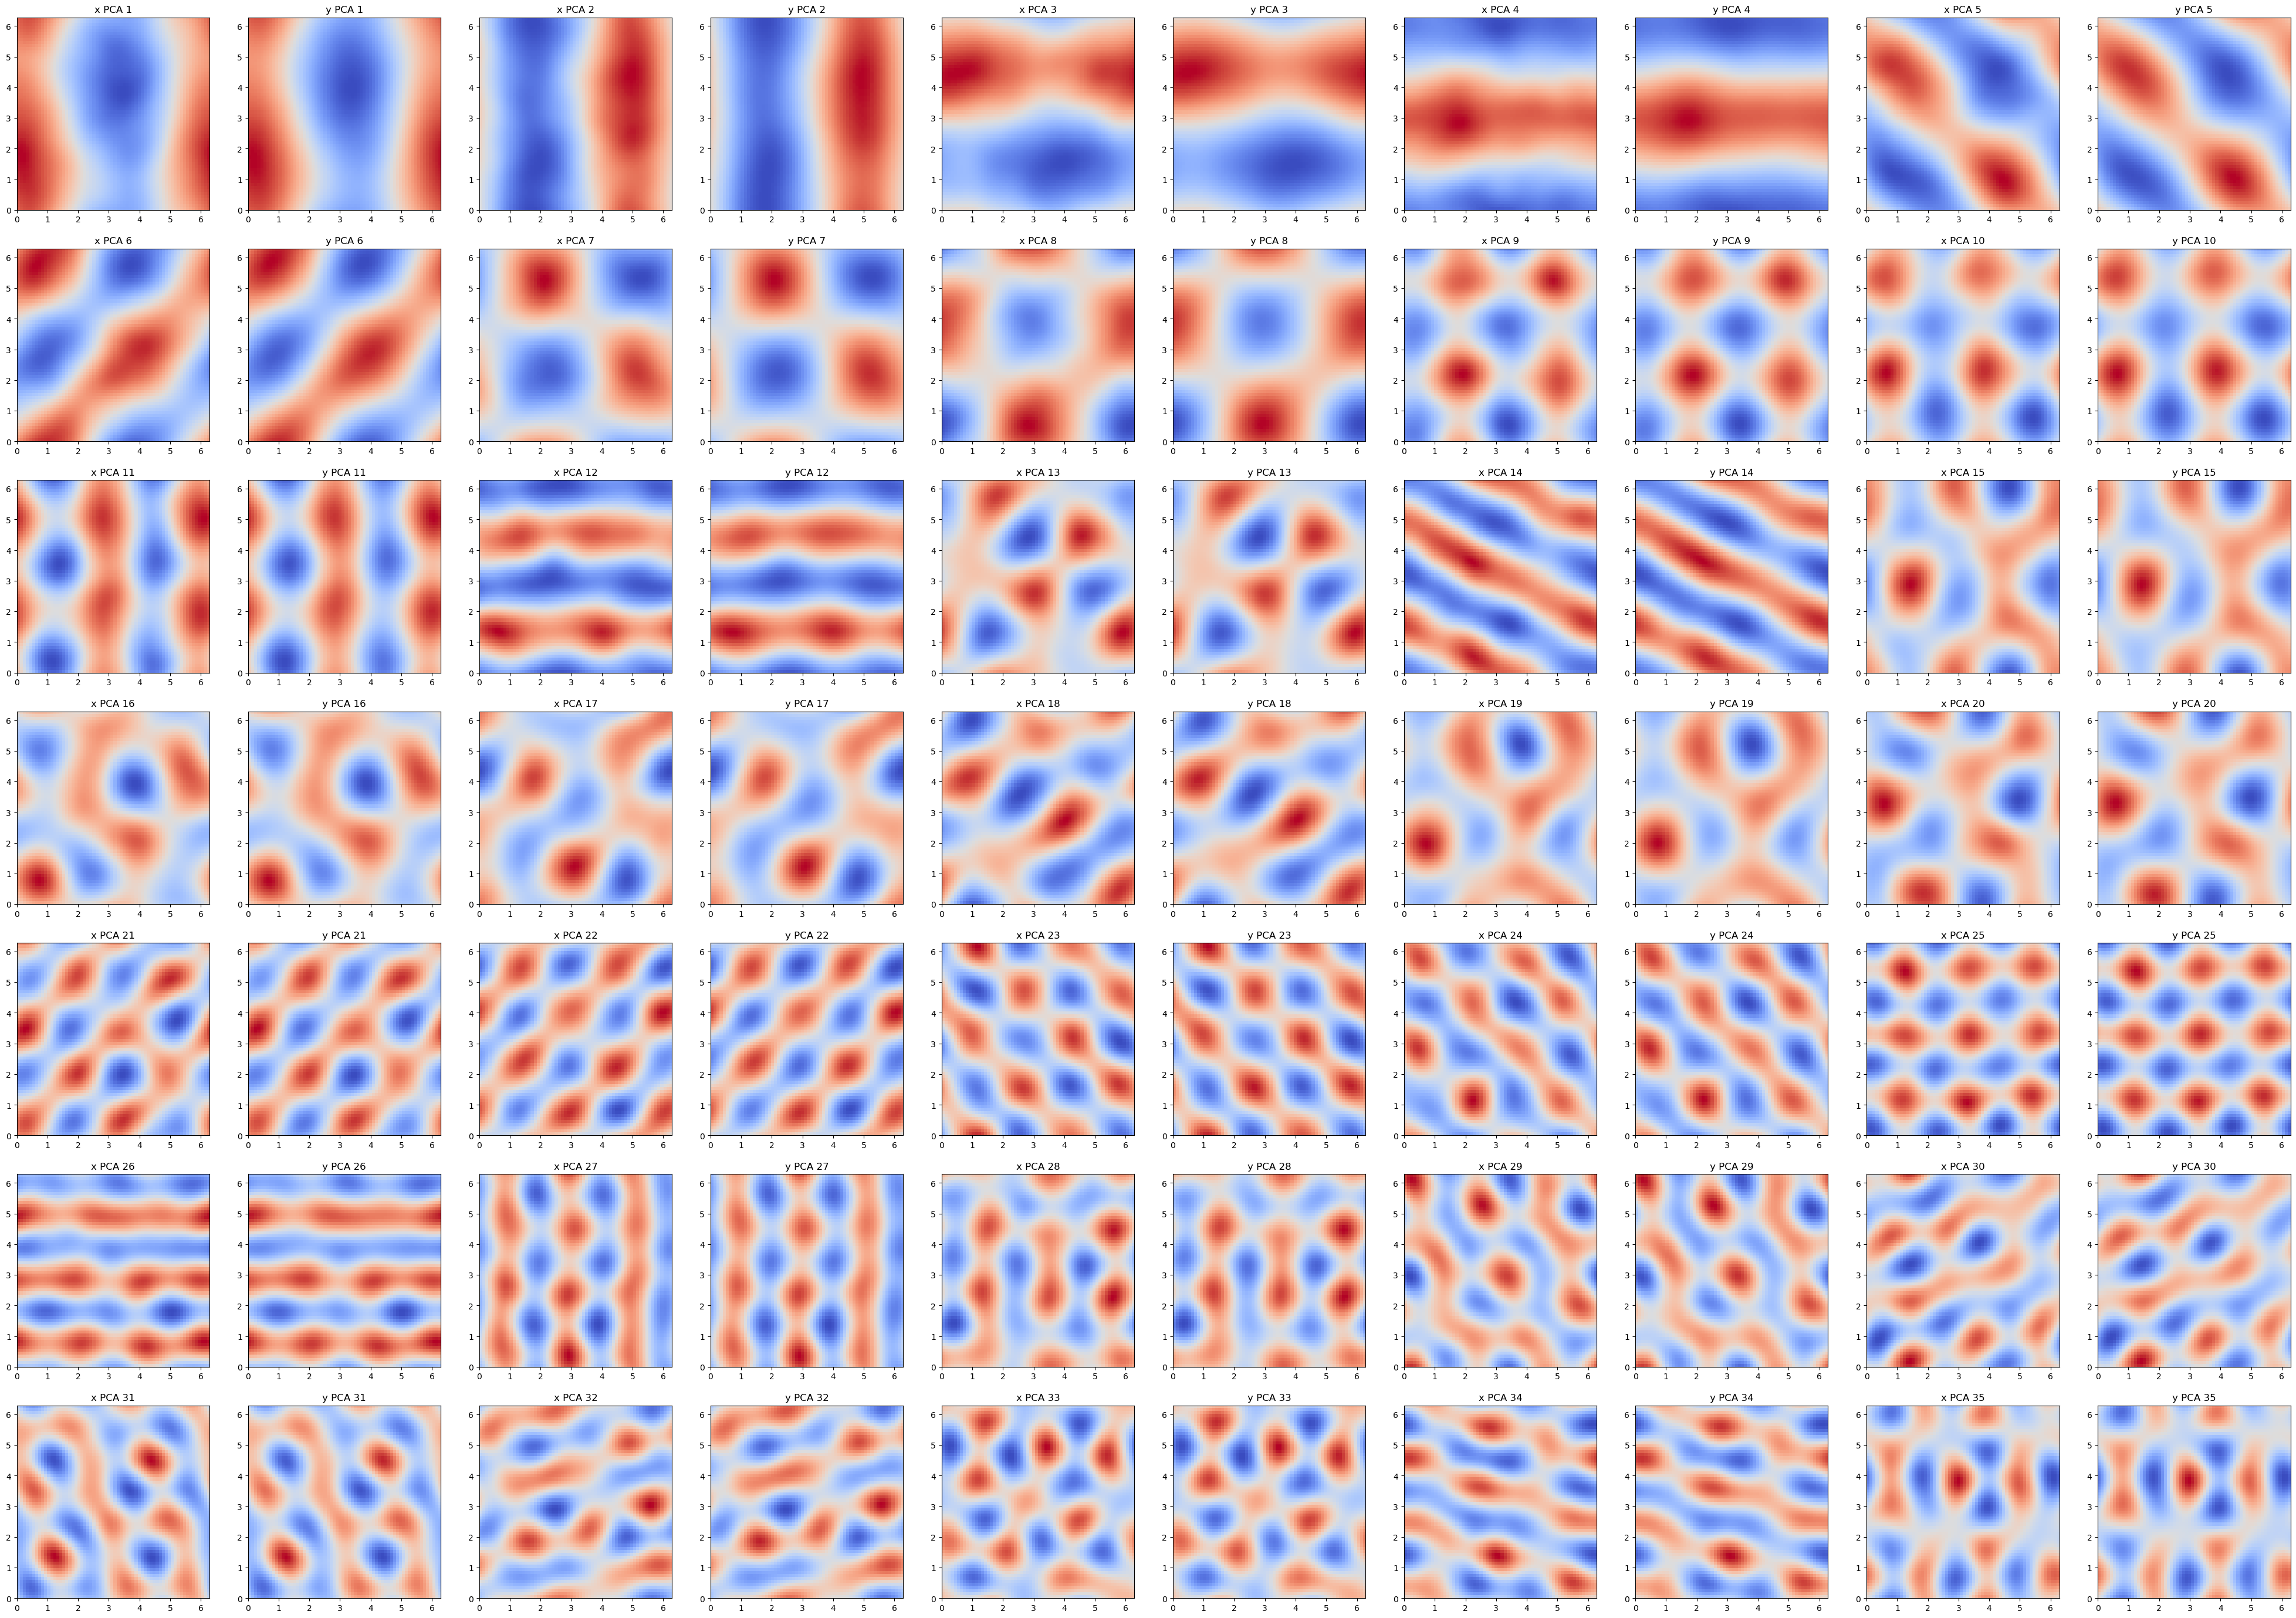

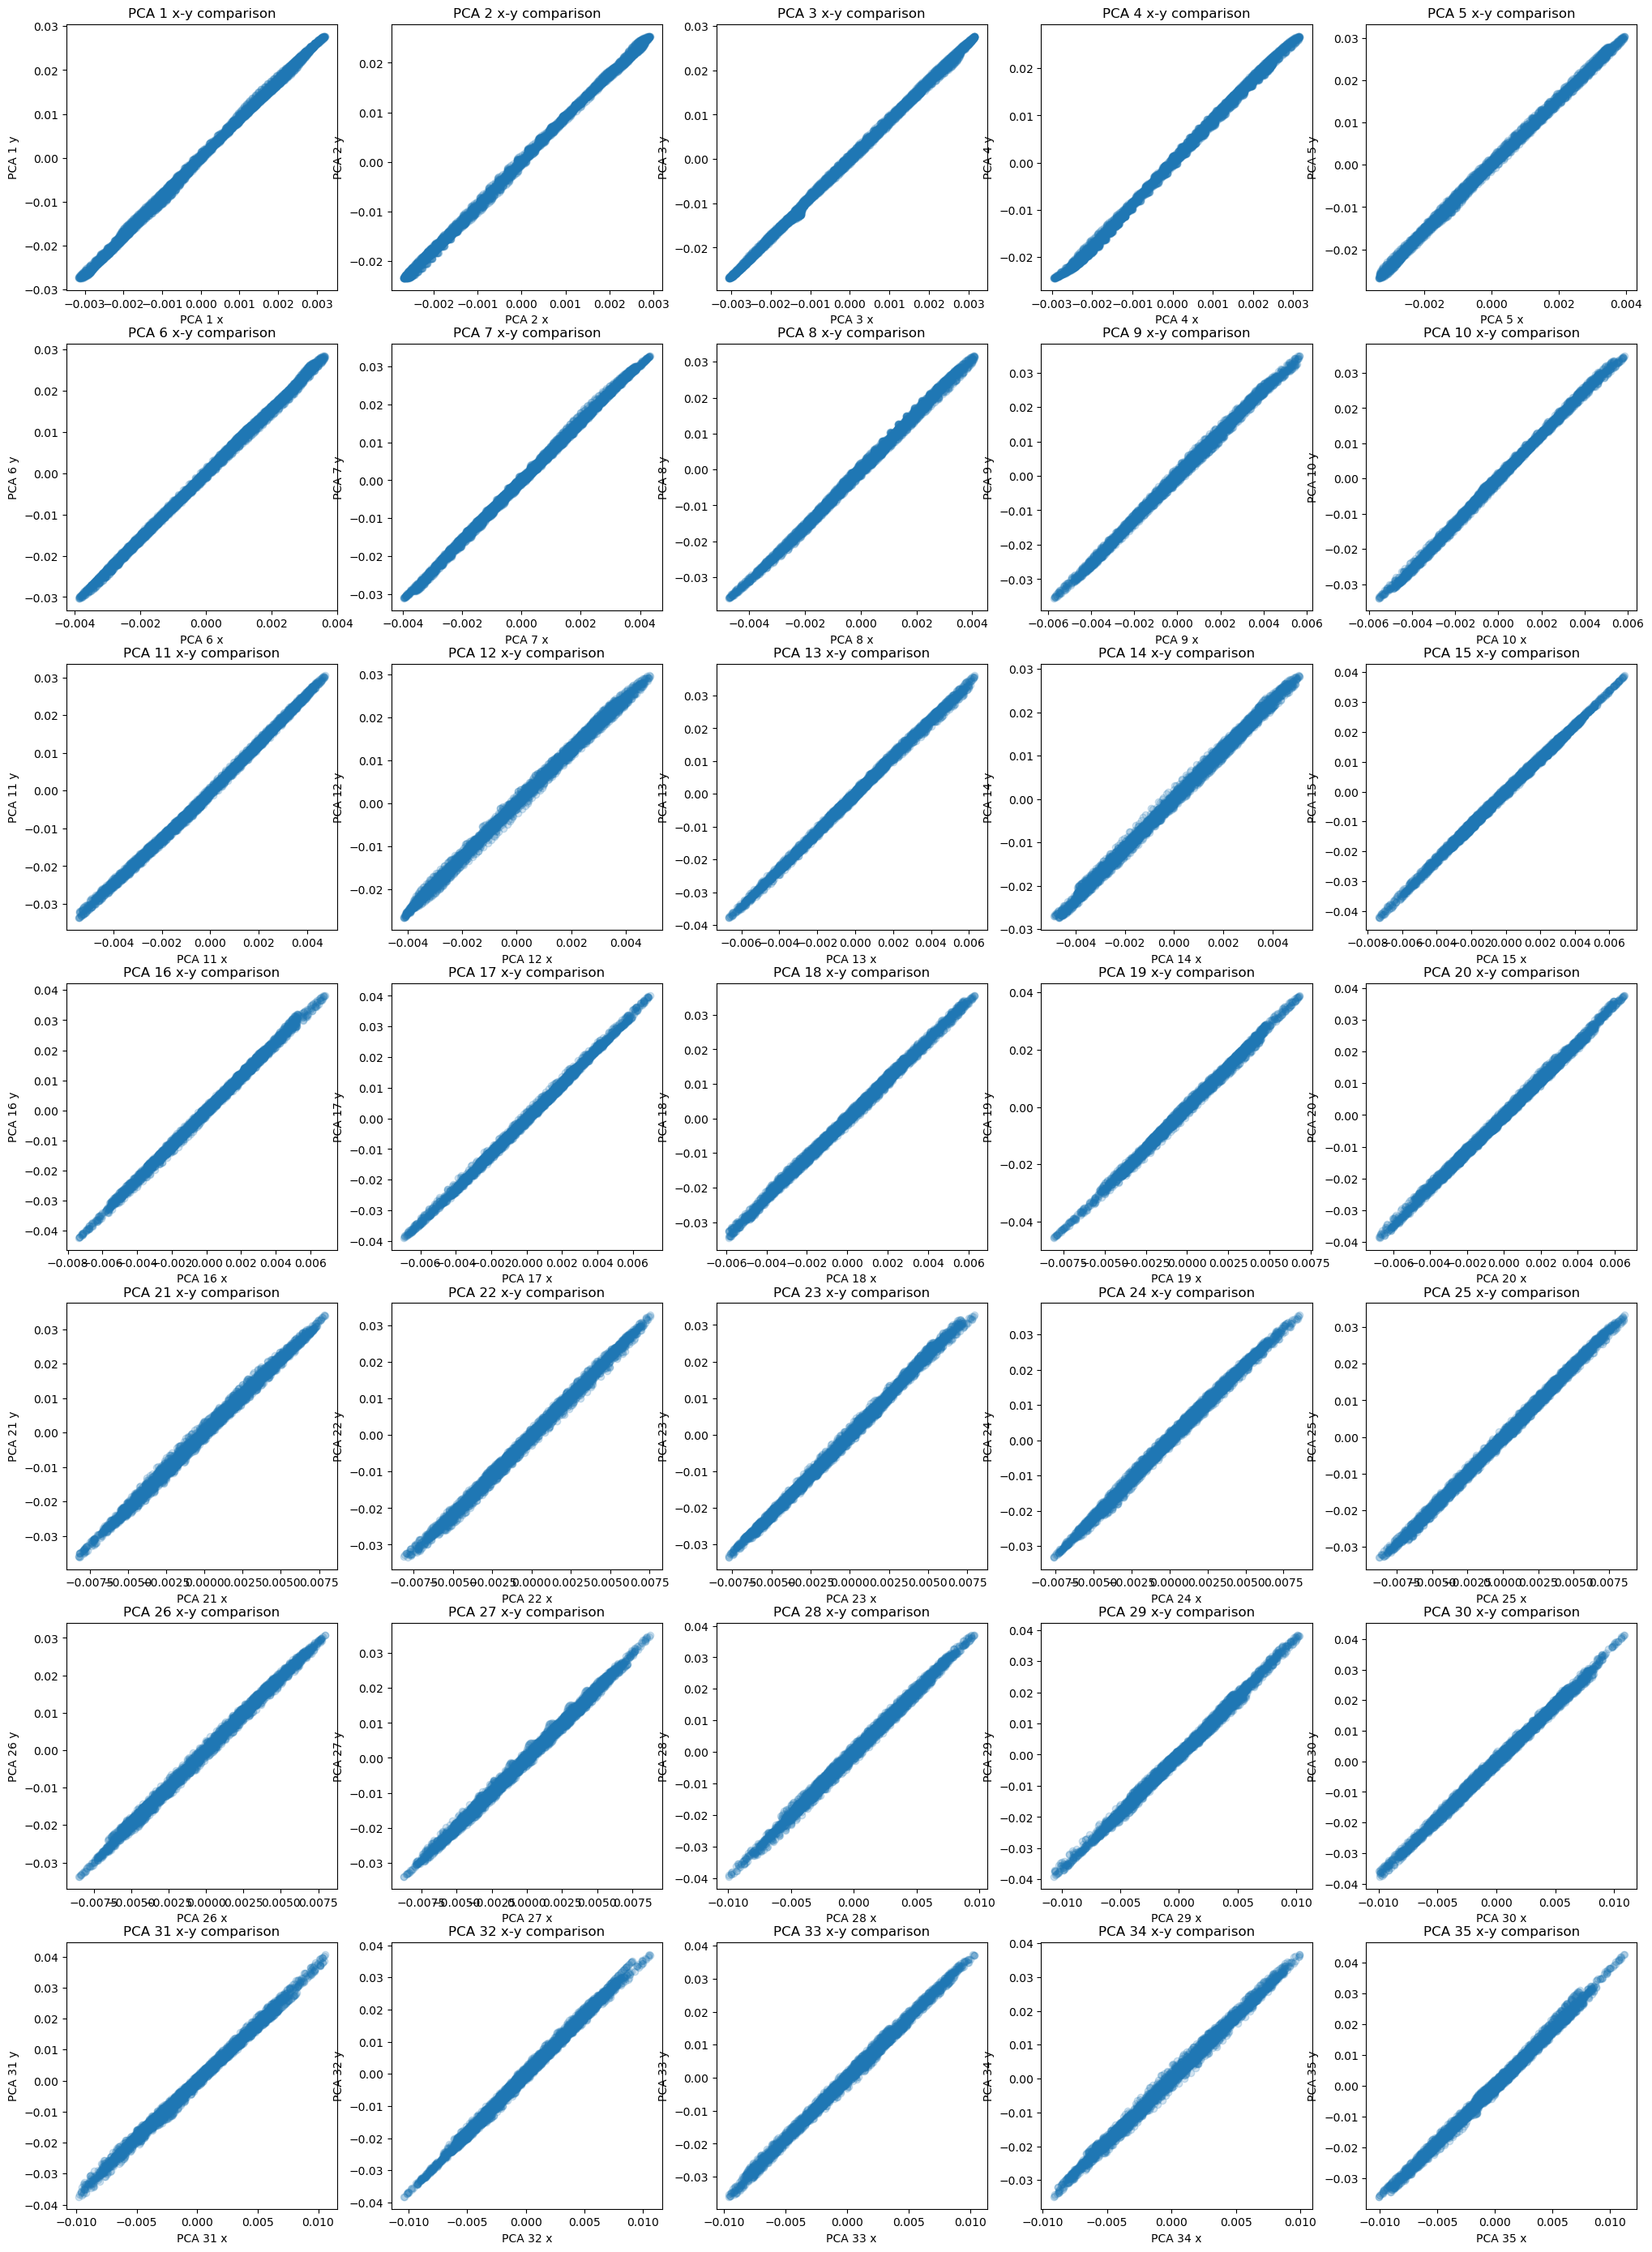

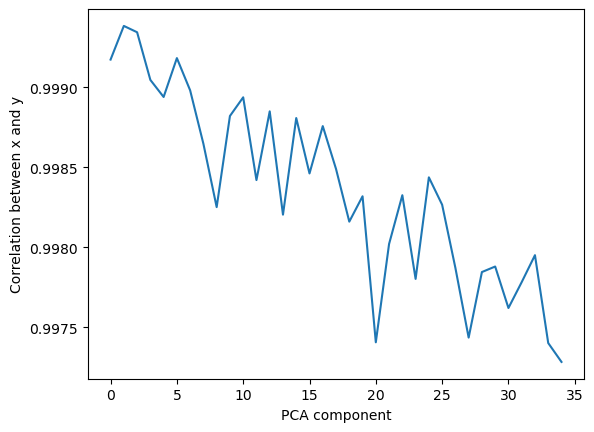

(1000, 45)


In [ ]:
# stack x_train and y_train

combined_train = np.concatenate((x_train, y_train), axis = 1)
print(combined_train.shape)

combined_train_pca = PCA(n_components=45).fit(combined_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(combined_train_pca.components_[int(i/2), :4096].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(combined_train_pca.components_[int(i/2), 4096:].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(combined_train_pca.components_[i, :4096], combined_train_pca.components_[i, 4096:], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(combined_train_pca.components_[i, :4096], combined_train_pca.components_[i, 4096:])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

combined_train_pca = combined_train_pca.transform(combined_train)
print(combined_train_pca.shape)

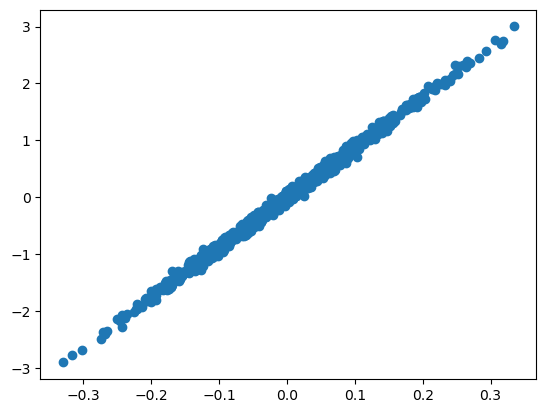

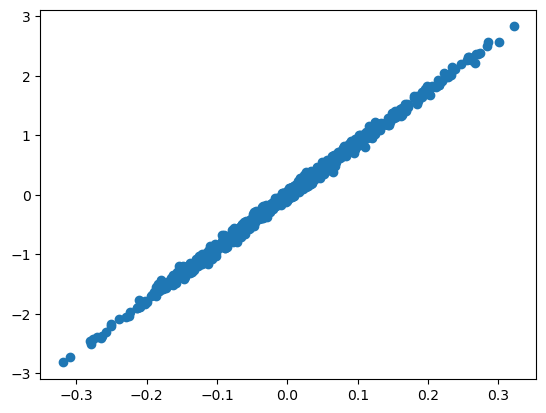

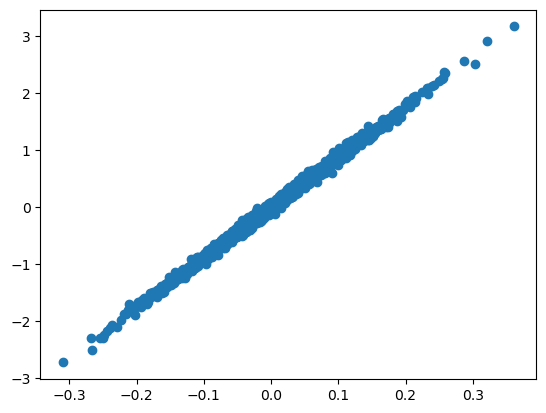

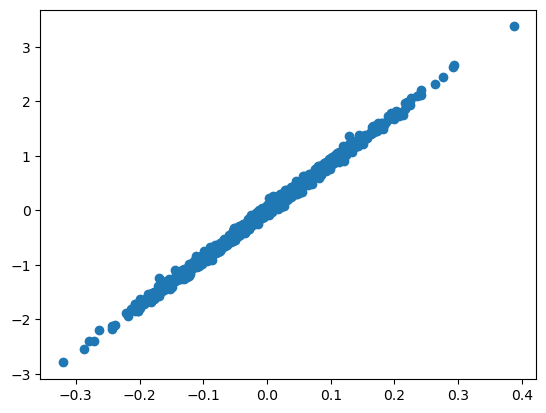

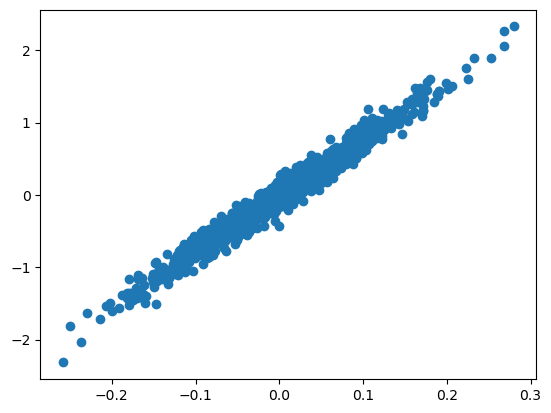

In [ ]:
for i in range(5):
    plt.figure()
    plt.plot(x_train_pca[:, i], y_train_pca[:, i], 'o')
    plt.show()

In [ ]:
## Train

n, m = 5, 5 # n, m = 45, 35 for variance explained 0.95, 0.99

model = full_model(n = n, m = m, ARD = False, multiinput = True, standardise = True, combine_pca = False)
train_samples = model.fit(x_train, y_train)

does combined pca
does x pca
does y pca


  0%|          | 0/5 [00:00<?, ?it/s]

[1.]
float64


 20%|██        | 1/5 [00:08<00:35,  8.80s/it]

Optimization terminated successfully.
         Current function value: -1959.447235
         Iterations: 14
         Function evaluations: 20
         Gradient evaluations: 20
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.37752769], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0314717], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 40%|████      | 2/5 [00:42<01:10, 23.38s/it]

         Current function value: -2048.695217
         Iterations: 48
         Function evaluations: 121
         Gradient evaluations: 109
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([20.11270264], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.02870916], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 60%|██████    | 3/5 [01:10<00:51, 25.51s/it]

         Current function value: -1945.440550
         Iterations: 48
         Function evaluations: 104
         Gradient evaluations: 94
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([21.12035152], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03194613], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 80%|████████  | 4/5 [01:22<00:20, 20.05s/it]

         Current function value: -1859.628776
         Iterations: 15
         Function evaluations: 46
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([20.81411597], dtype=float64), variance=Array([9.99999112], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03487173], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
100%|██████████| 5/5 [01:41<00:00, 20.23s/it]

         Current function value: -1593.548095
         Iterations: 16
         Function evaluations: 87
         Gradient evaluations: 75
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.24351328], dtype=float64), variance=Array([9.99999907], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04587497], dtype=float64))
[2.]
[1.]


In [ ]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


(1000, 4096, 6)
median relative L2 (train data): 0.6705989588057726
mean relative L2 (train data): 0.6713446894796862


(1000, 4096, 6)


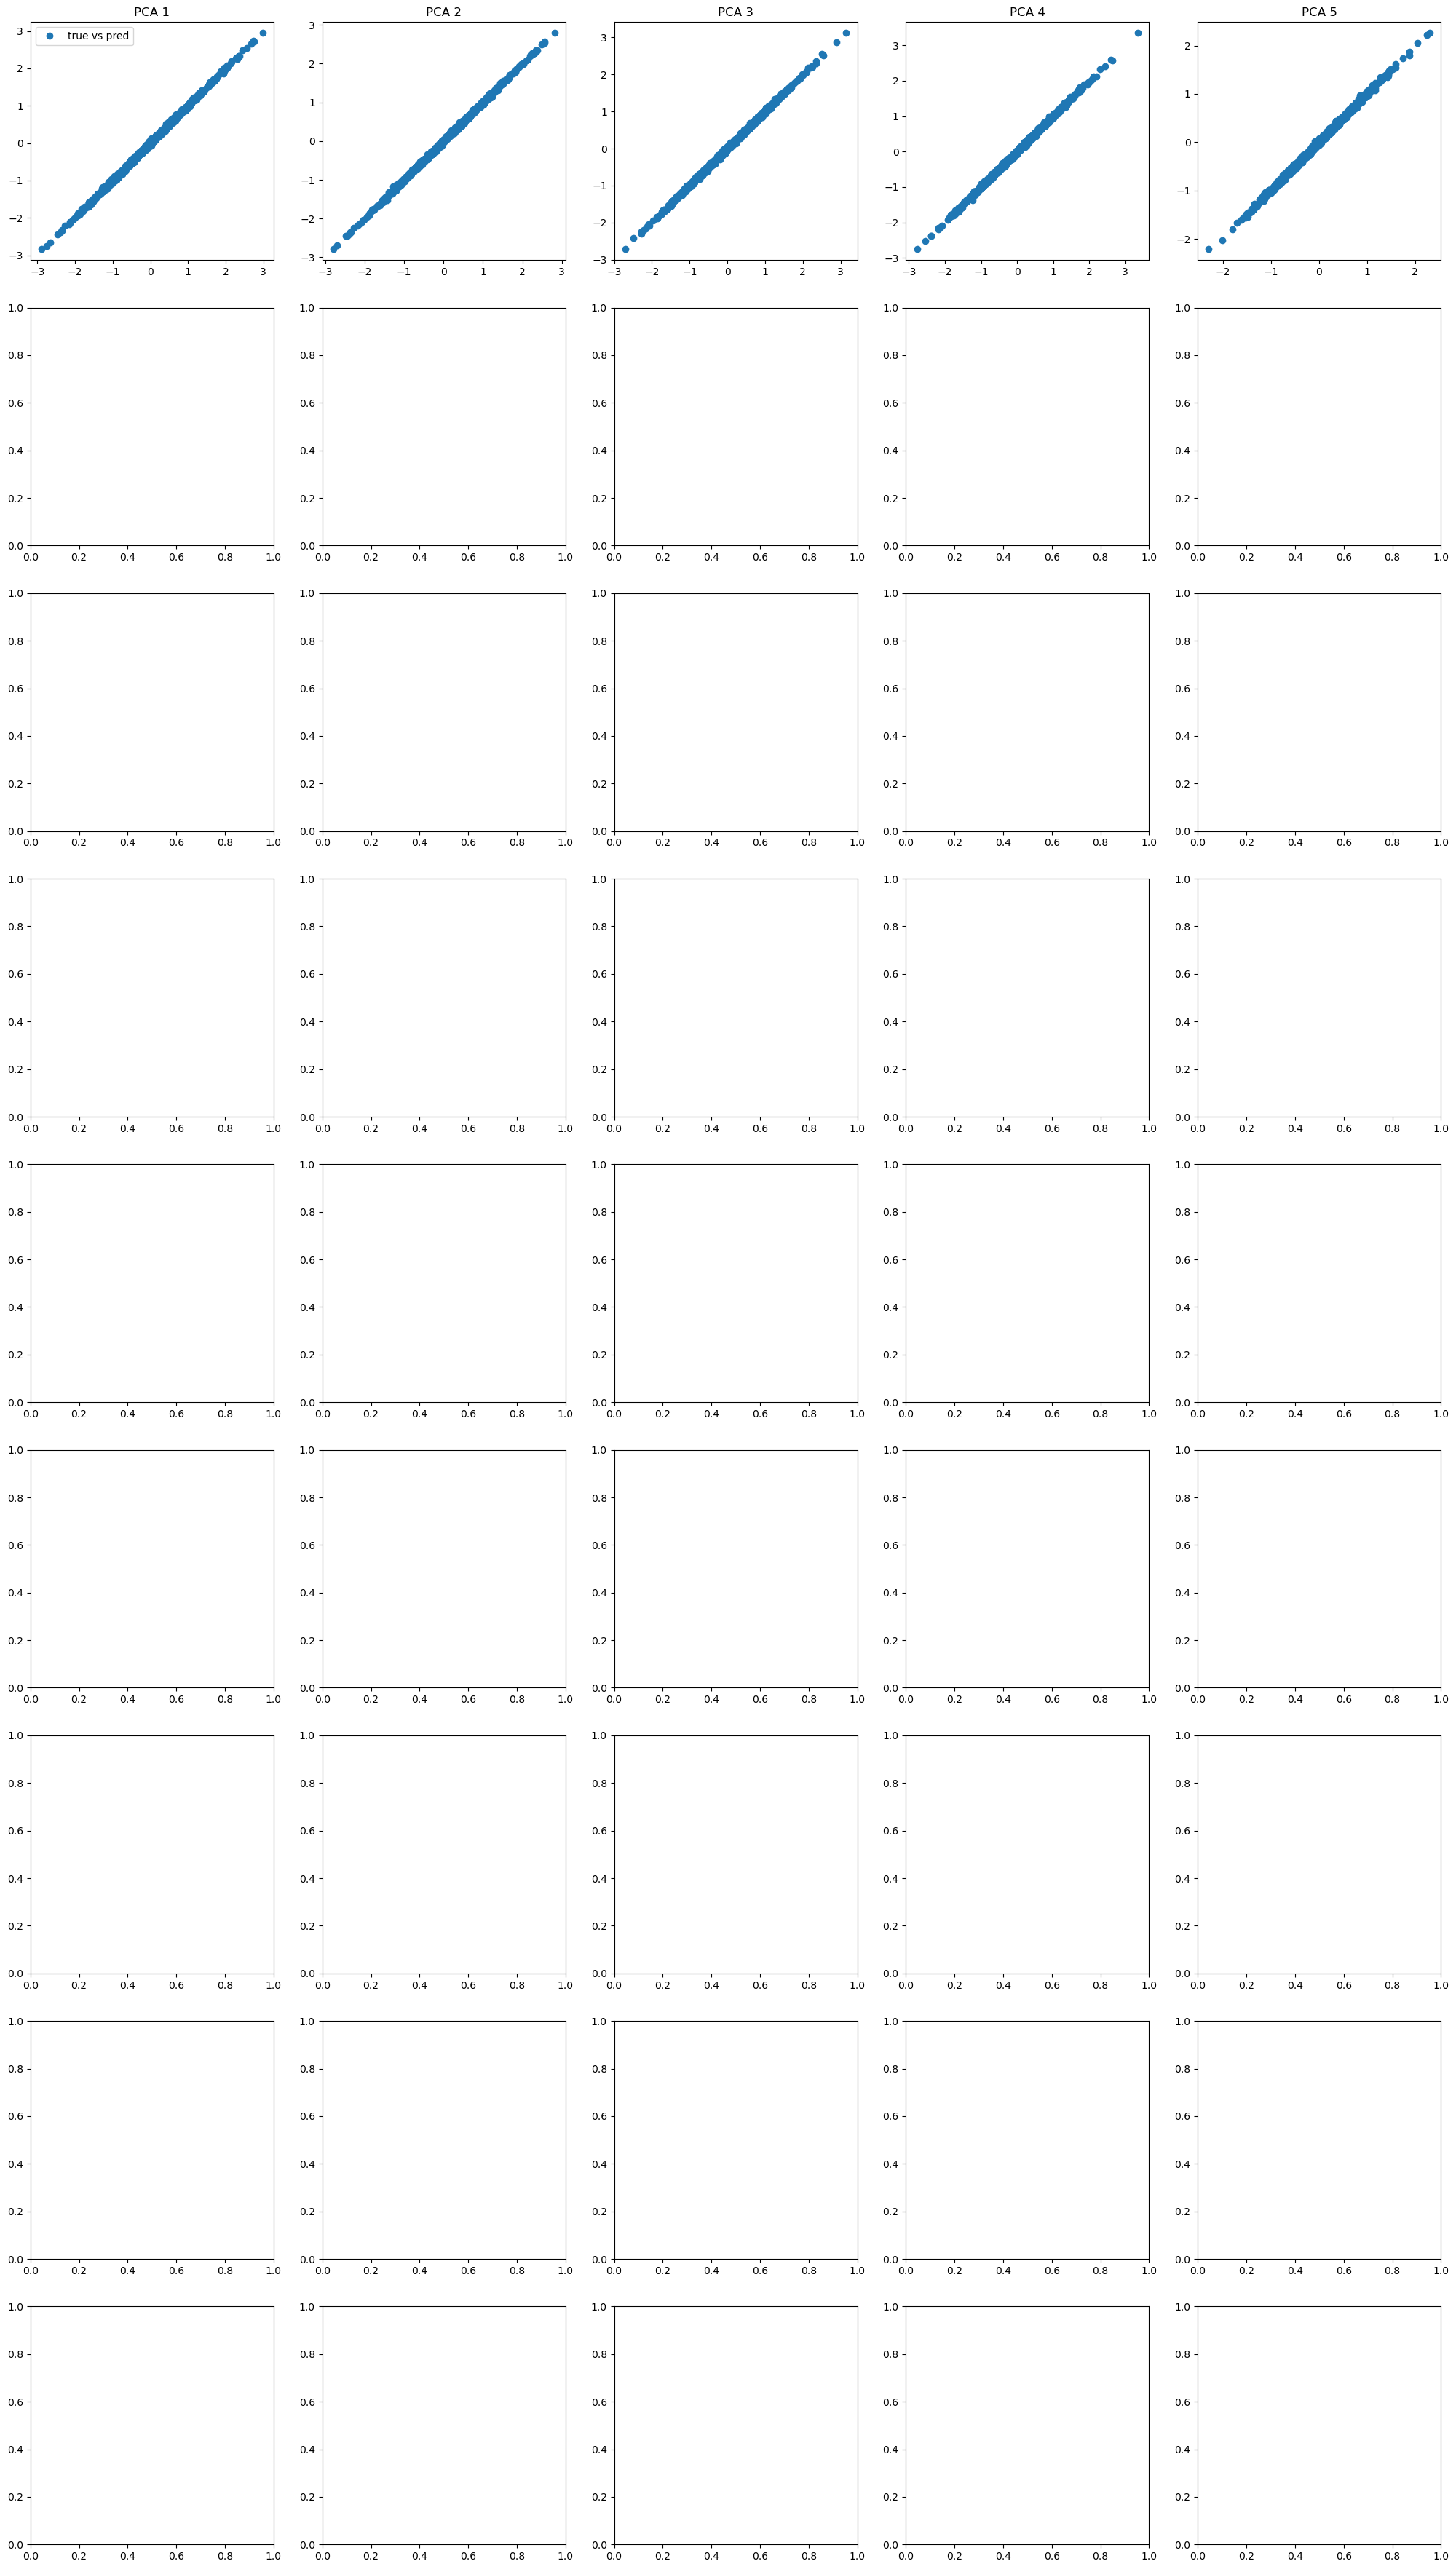

In [ ]:
x_train_pca = model.x_test_pca
y_train_pca = model.y_pca.transform(y_train)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_train_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

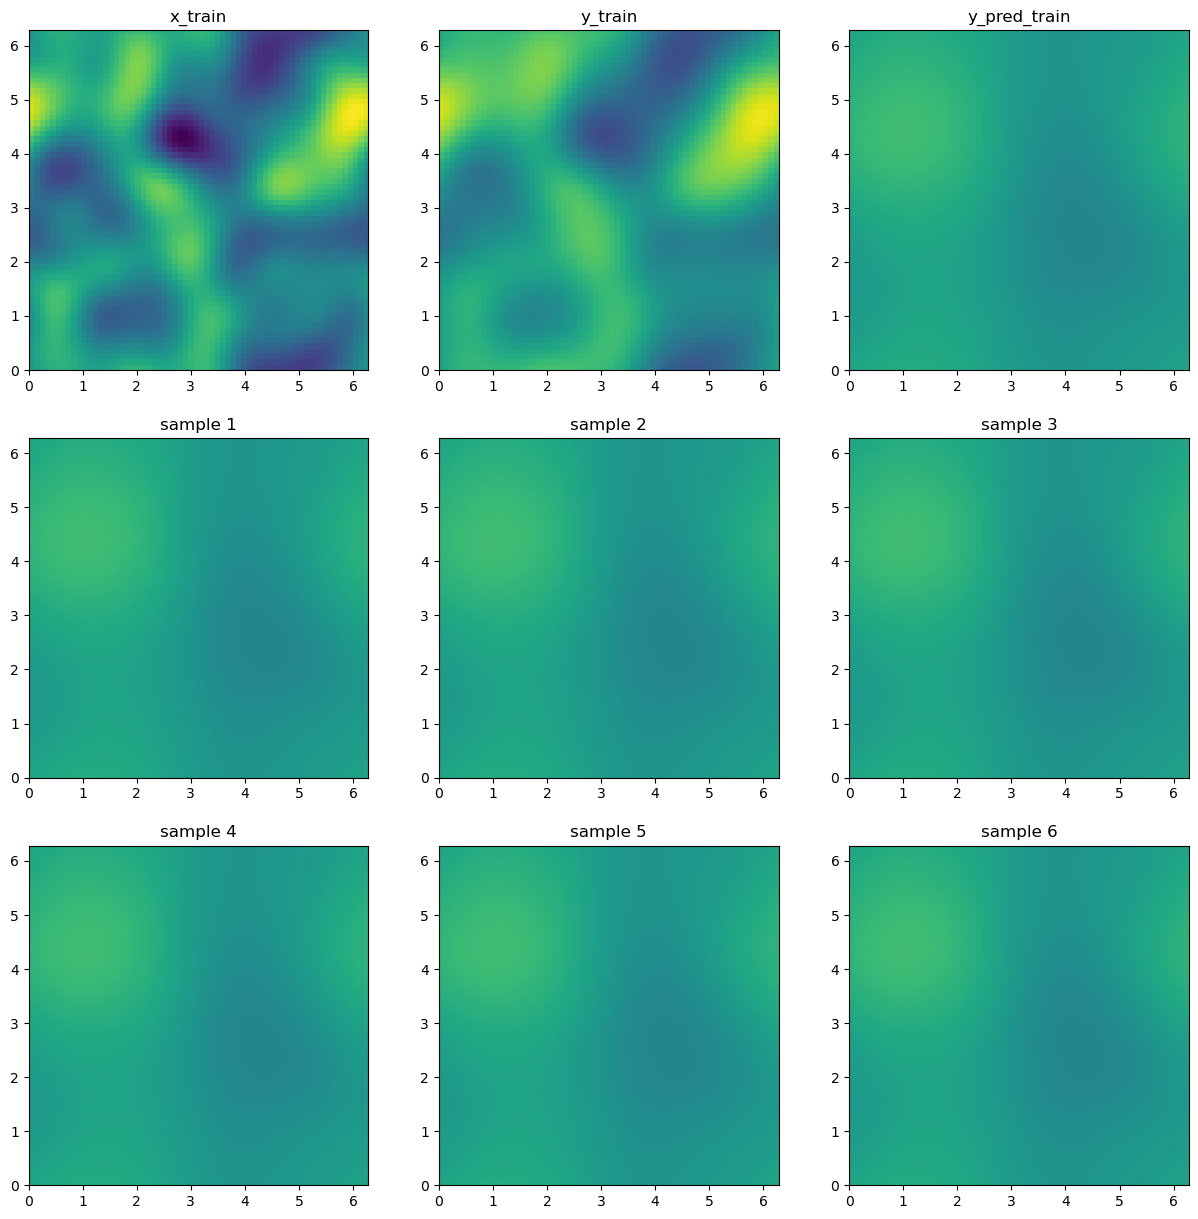

In [ ]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_train")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_train")
im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_train")
for i in range(6):
    imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

# testing

In [ ]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


median relative L2: 0.6655370814528673
mean relative L2: 0.6708015134715336


(1000, 4096, 6)


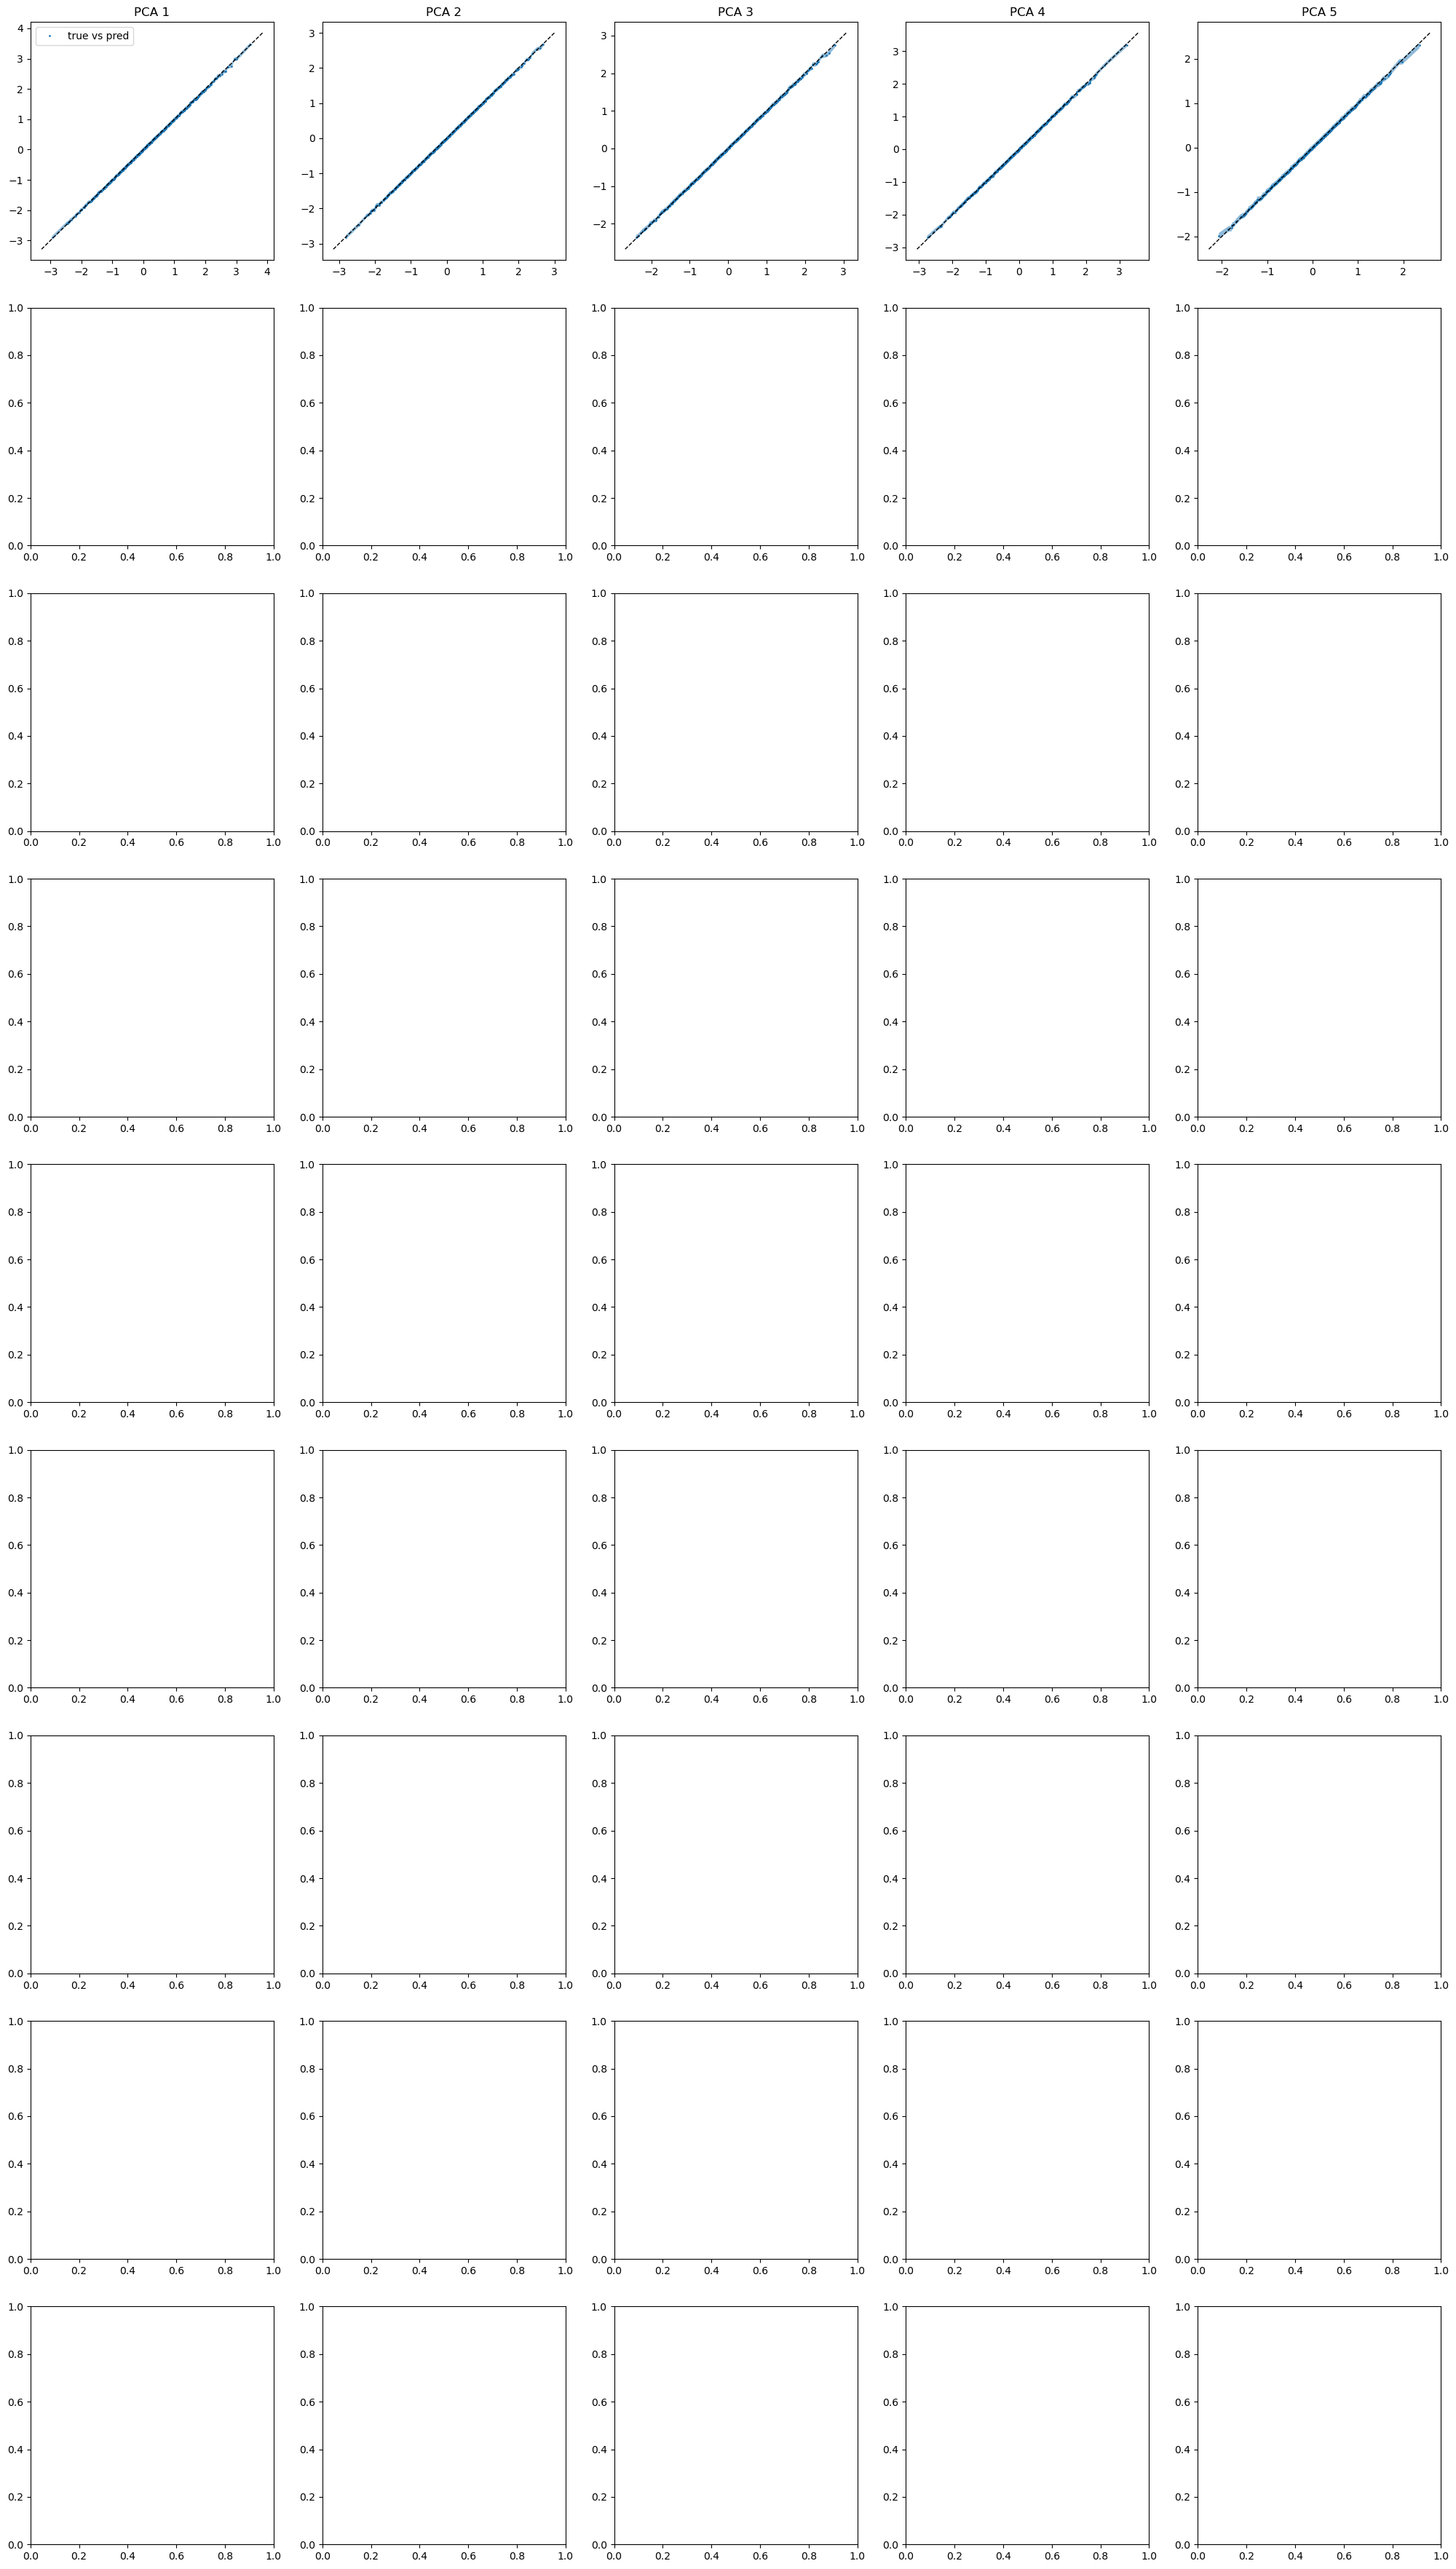

In [ ]:
x_test_pca = model.x_test_pca
y_test_pca = model.y_pca.transform(y_test)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(model.y_pred_pca[:, 0, i])], 'o', label = 'true vs pred', ms = 1)
    ax[i].fill_between(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 1, i][np.argsort(model.y_pred_pca[:, 0, i])], model.y_pred_pca[:, 2, i][np.argsort(model.y_pred_pca[:, 0, i])], alpha = 0.5)
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 1, i], 'o', label = r'true vs (pred - 2$\sigma$)')
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 2, i], 'o', label = r'true vs (pred + 2$\sigma$)')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

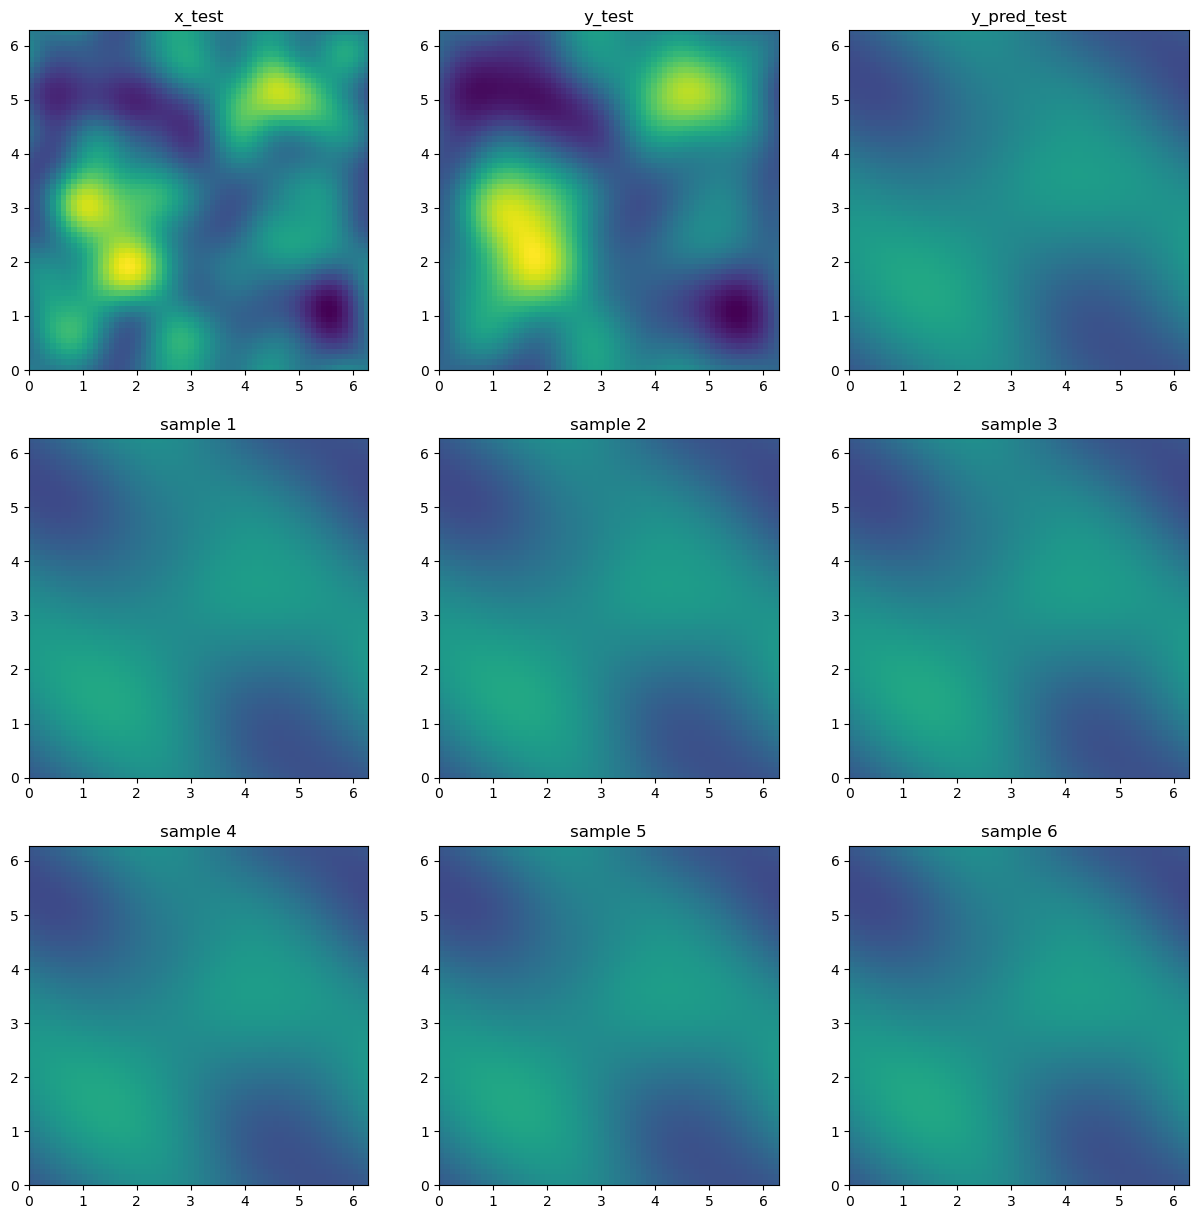

In [ ]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_test")
im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_test")
for i in range(6):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## analyse uncertainty

In [ ]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(1000, 4096, 100)


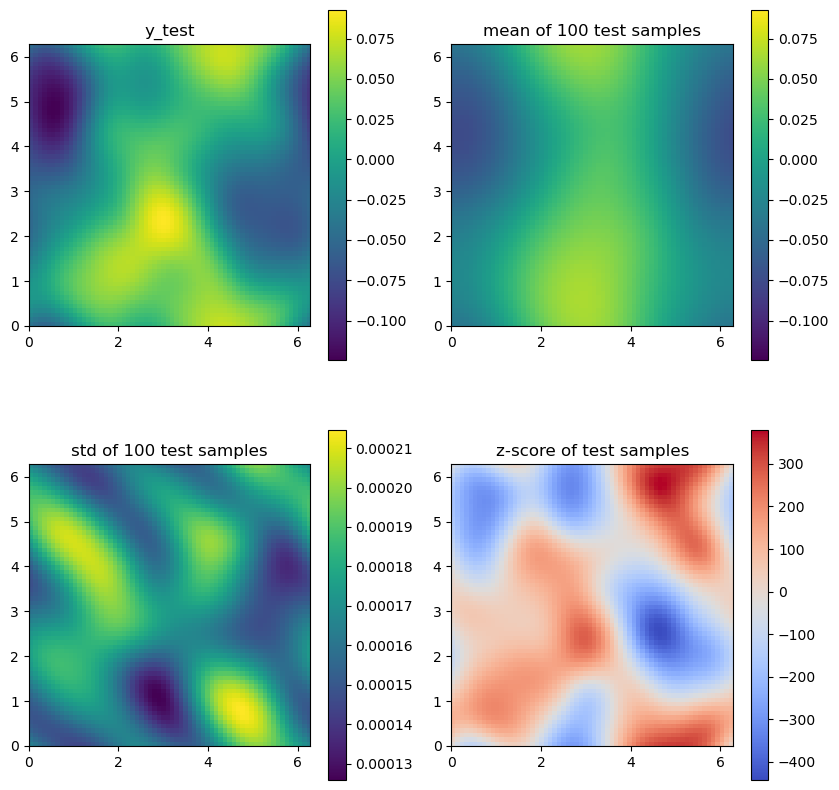

In [ ]:
index_to_plot = 126

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

im0 = ax[0].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[0].set_title("y_test")
im1 = ax[1].imshow(test_samples_mean[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title(f"mean of {n_samples} test samples")
im2 = ax[2].imshow(test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[2].set_title(f"std of {n_samples} test samples")
im3 = ax[3].imshow((y_test[index_to_plot, :].reshape(64, 64) - test_samples_mean[index_to_plot, :].reshape(64, 64)) / test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap = 'coolwarm')
ax[3].set_title(f"z-score of test samples")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])


Linear regression baseline

1000 128
0.05201371315454107 0.05782591678481767


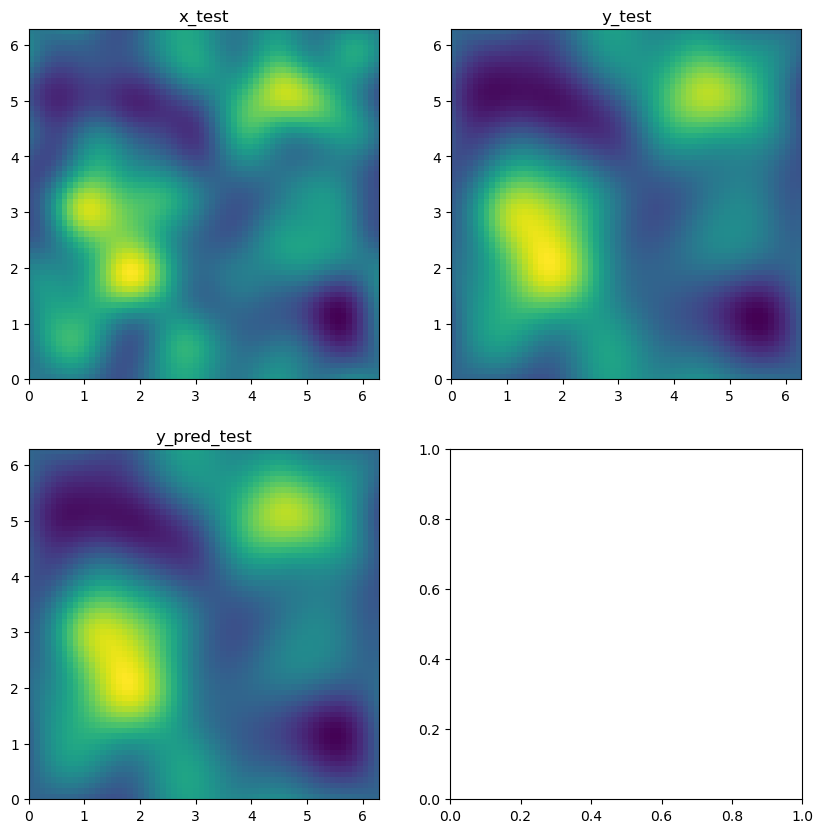

1000 256
0.052013722829797174 0.05782587333101374


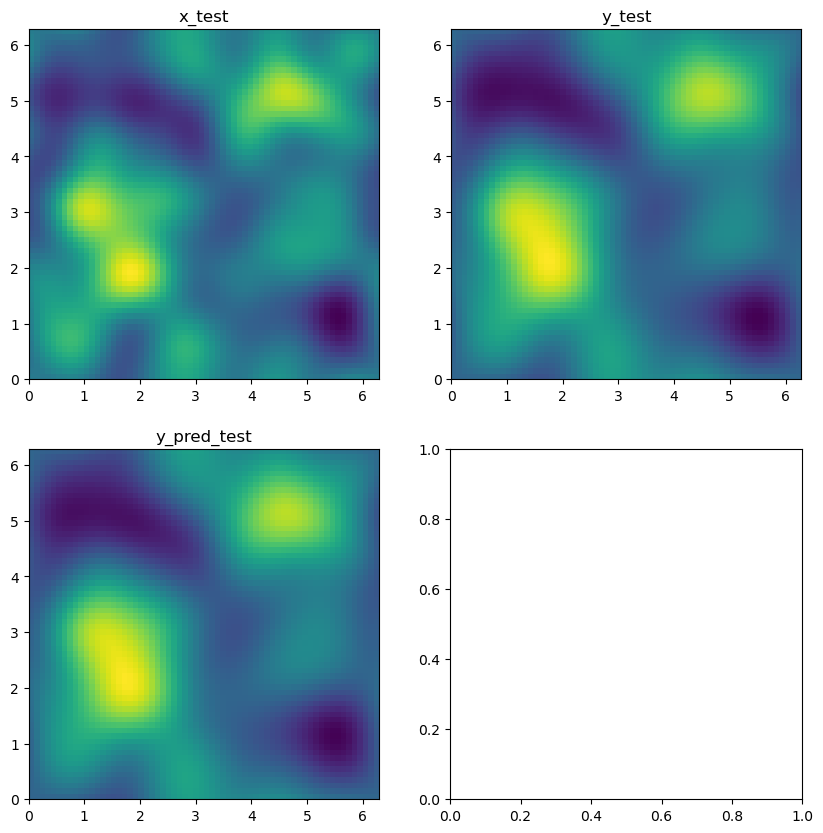

1000 512
0.052014543228808906 0.057826035898965206


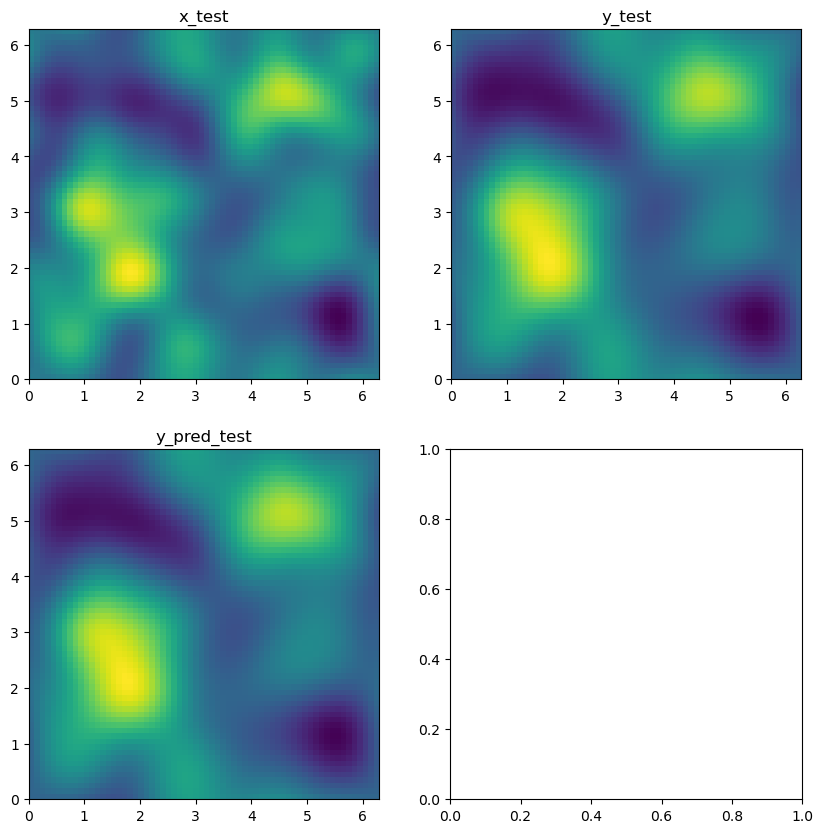

1000 1024
0.051470239119434616 0.0588309934177186


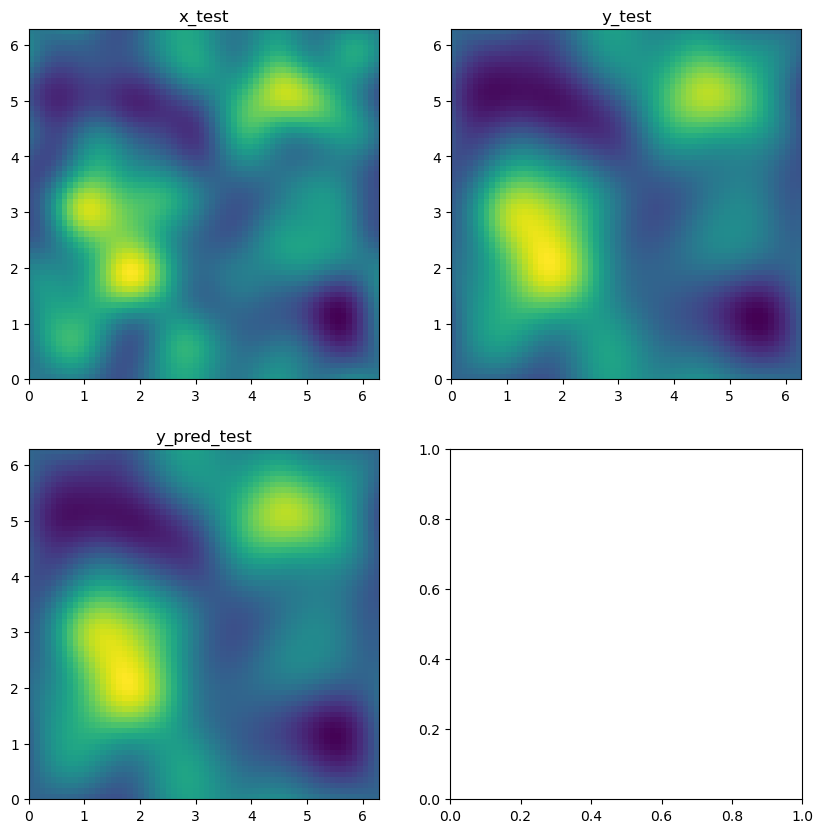

In [ ]:
results = []
for Ntrain in [1000]:
    for N_components in [128, 256, 512, 1024]:
        print(Ntrain, N_components)
        Ytr = y_train
        Xtr = x_train
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        #Ypred Ypredtr = reg.predict(Xtr)
        Ypredtr = reg.predict(Xtr)
        train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        Xtest = x_test
        Ytest = y_test
        Xtest = pca.transform(Xtest)
        Ypred = reg.predict(Xtest)
        test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(train_error, test_error)
        results.append([Ntrain, N_components, train_error, test_error])

        index_to_plot = 125

        y_lims = np.array([min(y_test[index_to_plot, :].min(), Ypred[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), Ypred[index_to_plot, :].max())])

        fig, ax = plt.subplots(2, 2, figsize = (10, 10))
        ax = ax.flatten()
        im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
        ax[0].set_title("x_test")
        im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[1].set_title("y_test")
        im2 = ax[2].imshow(Ypred[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[2].set_title("y_pred_test")
        plt.show()

results = np.array(results)